In [12]:
import cv2
import numpy as np
from keras.models import load_model, Model
from matplotlib import pyplot as plt
import math
import imgaug as ia
from imgaug import augmenters as iaa
import os
import sys
import keras.backend as K

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
import utils

In [2]:
darknet19_model = load_model('../data/darknet19_hpluso.h5')
darknet19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 64)      18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 64)      256       
__________

/home/aaron/anaconda3/envs/tf_cu9/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# dataset_dir = '/media/aaron/DATA/ubuntu/fpha-dataset/'
dataset_dir = '/media/aaron/DATADRIVE1/First_Person_Action_Benchmark'
image_dir = os.path.join(dataset_dir, 'Video_files')
annot_dir = os.path.join(dataset_dir, 'Hand_pose_annotation_v1')

img_details = ['Subject_1', 'put_salt', '1']

sample = {
    'subject': img_details[0],
    'action_name': img_details[1],
    'seq_idx': img_details[2],
    'frame_idx': 0,
    'object': None
}

img_color_path = os.path.join(image_dir, 
                   sample['subject'], 
                   sample['action_name'],
                   sample['seq_idx'],
                   'color',
                   'color_%04d.jpeg' %sample['frame_idx'])
img = cv2.imread(img_color_path)[:,:,::-1]

In [15]:
reorder_idx = np.array([
    0, 1, 6, 7, 8, 2, 9, 10, 11, 3, 12, 13, 14, 4, 15, 16, 17, 5, 18, 19,
    20
])

skel_raw = utils.get_skeleton(sample, annot_dir)[reorder_idx]

H = 13
W = 13
D = 5
img_H = 416
img_W = 416

cam_extr = np.array(
    [[0.999988496304, -0.00468848412856, 0.000982563360594,
      25.7], [0.00469115935266, 0.999985218048, -0.00273845880292, 1.22],
     [-0.000969709653873, 0.00274303671904, 0.99999576807,
      3.902], [0, 0, 0, 1]])

cam_intr = np.array([[1395.749023, 0, 935.732544],
                    [0, 1395.749268, 540.681030], 
                    [0, 0, 1]])
inv_cam_intr = np.linalg.inv(cam_intr)
print(inv_cam_intr)
skel_hom = np.concatenate([skel_raw, np.ones([skel_raw.shape[0], 1])], 1)
# print('skel_hom=', skel_hom)
skel_camcoords = cam_extr.dot(
    skel_hom.transpose()).transpose()[:, :3].astype(np.float32)
# print('skel_camcoords=', skel_camcoords)

skel_hom2d_color = np.array(cam_intr).dot(skel_camcoords.transpose()).transpose()
skel_uvd_gt = skel_hom2d_color
skel_uvd_gt[:, :2] =  (skel_uvd_gt[:, :2]/skel_uvd_gt[:, 2:])
skel_xyz_gt = skel_camcoords



Loading skeleton from /media/aaron/DATADRIVE1/First_Person_Action_Benchmark/Hand_pose_annotation_v1/Subject_1/put_salt/1/skeleton.txt
[[ 7.16461186e-04  0.00000000e+00 -6.70416048e-01]
 [ 0.00000000e+00  7.16461060e-04 -3.87376904e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


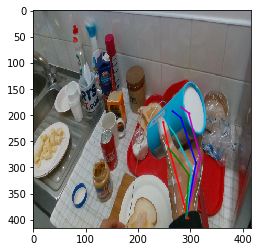

In [5]:
#color
seq = iaa.Sequential([
    iaa.size.Resize({"height": img_H, "width": img_W}),
])

seq_det = seq.to_deterministic()

skel_color_kps = []
for kps in skel_uvd_gt:
    skel_color_kps.append(ia.Keypoint(x=kps[0],y=kps[1]))
skel_color_kpsoi = ia.KeypointsOnImage(skel_color_kps, shape=img.shape)

images_aug = seq_det.augment_images([img])[0]
skel_aug = seq_det.augment_keypoints([skel_color_kpsoi])[0]

skel_aug_proj = []
for kps in skel_aug.keypoints:
    skel_aug_proj.append([kps.x_int, kps.y_int])
skel_aug_proj = np.asarray(skel_aug_proj)

fig, ax = plt.subplots()
ax.imshow(images_aug)

utils.visualize_joints_2d(ax, skel_aug_proj, joint_idxs=False)

skel_uvd_gt_rsz = np.concatenate([skel_aug_proj, np.reshape(skel_uvd_gt[:, 2], (21, 1))], 1)
skel_xyz_gt_rsz = skel_uvd_gt_rsz*skel_uvd_gt[:, 2:]
skel_xyz_gt_rsz = np.reshape(np.array(inv_cam_intr).dot(skel_uvd_gt.transpose()).transpose(), -1)

In [6]:
min_u = np.amin(skel_uvd_gt_rsz[:, 0])
max_u = np.amax(skel_uvd_gt_rsz[:, 0])
min_v = np.amin(skel_uvd_gt_rsz[:, 1])
max_v = np.amax(skel_uvd_gt_rsz[:, 1])
min_z = np.amin(skel_uvd_gt_rsz[:, 2])
max_z = np.amax(skel_uvd_gt_rsz[:, 2])

print('min_u=', min_u)
print('max_u=', max_u)
print('min_v=', min_v)
print('max_v=', max_v)
print('min_z=', min_z)
print('max_z=', max_z)

min_u= 248.0
max_u= 320.0
min_v= 185.0
max_v= 397.0
min_z= 319.8966064453125
max_z= 444.5054931640625


In [7]:
img_rsz = images_aug
img_rsz = np.expand_dims(img_rsz, axis=0)
predict = darknet19_model.predict(img_rsz)
predict = np.reshape(predict, (H, W, D, 64))

In [8]:
def sigmoid(gamma):
  if gamma < 0:
    return 1 - 1/(1 + math.exp(gamma))
  else:
    return 1/(1 + math.exp(-gamma))

C_u = img_W/W
C_v = img_H/H
C_z = 120 #mm
a = 2 #sharpness
d_th = 75

pred_poses_xyz = np.zeros((W, H, D, 63))
pred_conf = np.zeros((W, H, D, 1))
conf_gt = np.zeros((W, H, D, 1)) 

for u in range(0, W):
    for v in range(0, H):
        for z in range(0, D):
            pred_offset = predict[u, v, z, :63]
            pred_offset = np.reshape(pred_offset, (21,3))
            pred_hand_pose = np.zeros(pred_offset.shape)
            for i, offset in enumerate(pred_offset):
                #wrist contrained in cell
                if i == 0:
                    w_u = sigmoid(offset[0])
                    w_v = sigmoid(offset[1]) + v
                    w_z = sigmoid(offset[2]) + z
                else:
                    w_u = offset[0] + u
                    w_v = offset[1] + v
                    w_z = offset[2] + z
                pred_hand_pose[i, :] = [w_u, w_v, w_z]

            DT_uv = np.linalg.norm(pred_hand_pose[:, :2] - skel_uvd_gt[:, :2])
            
            if DT_uv < d_th:
                conf_uv = math.exp(a*(1-(DT_uv/d_th)))
            else:
                conf_uv = 0
            
            DT_z = np.linalg.norm(pred_hand_pose[:, 2] - skel_uvd_gt[:, 2])
            
            if DT_z < d_th:
                conf_z = math.exp(a*(1-(DT_z/d_th)))
            else:
                conf_z = 0
            
            conf = 0.5*conf_uv + 0.5*conf_z
            
            pred_hand_pose[:, 0] = C_u*pred_hand_pose[:, 0]
            pred_hand_pose[:, 1] = C_v*pred_hand_pose[:, 1]
            pred_hand_pose[:, :2] = C_z*pred_hand_pose[:, :2]*pred_hand_pose[:, 2:]

            pred_poses_xyz[u, v, z, :] = np.reshape(np.array(inv_cam_intr).dot(pred_hand_pose.transpose()).transpose(), -1)
            pred_conf[u, v, z, :] = predict[u, v, z, 63]
            conf_gt[u, v, z, :] = conf
    

In [9]:
pose_loss = 0
pred_poses_xyz = np.reshape(pred_poses_xyz, (-1, 63))
for pose in pred_poses_xyz:
    pose_loss += np.linalg.norm(pose - skel_xyz_gt_rsz)
print('pose_loss=', pose_loss)

pose_loss= 46188898845.34897


In [10]:
hand_cell_range_u = list(range(int(min_u/C_u), math.ceil(max_u/C_u))) 
hand_cell_range_v = list(range(int(min_v/C_v), math.ceil(max_v/C_v))) 
hand_cell_range_z = list(range(int(min_z/C_z), math.ceil(max_z/C_z))) 

conf_loss = 0
for u in range(0, W):
    for v in range(0, H):
        for z in range(0, D):
            if (u in hand_cell_range_u) and (v in hand_cell_range_v) and (z in hand_cell_range_z):
                lamda_conf = 5
            else:
                lambda_conf = 0.1
            conf_loss += lambda_conf*np.linalg.norm(conf_gt[u,v,z] - pred_conf[u,v,z])
            
print('conf_loss=', conf_loss)

conf_loss= 166487.45727310187
